## Question 1
在真正拿到餐廳工作前，Sanjay 至少要先釐清：

1.平均可以領多少──用來和顧問工作的穩定年薪比較。

2.可能會多慘──收入波動及虧損機率是否在可承受範圍內。

透過簡易蒙地卡羅模擬，他能把「感覺」量化成看得見的數字與分布，做出更有把握的職涯選擇

平均月薪 (E[Profit])       : $15,101
月薪低於顧問薪資的機率     : 0.00%
最差 5% 月薪 (VaR 5%)      : $13,306


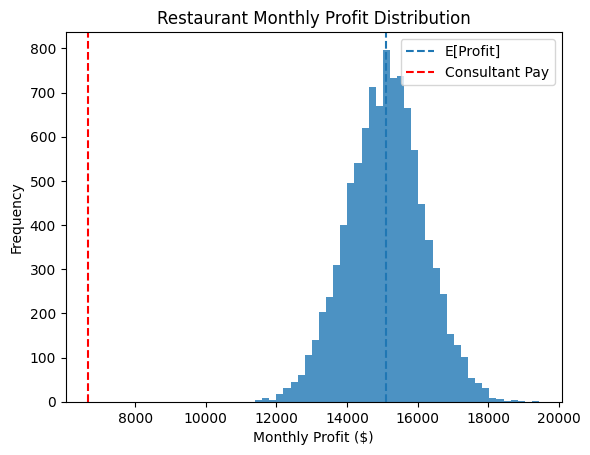

In [8]:
# 假設
# 平均每日來客數 120，標準差 20（可視淡旺季自行調整）。
# 每位顧客平均消費 $15。
# 食材等可變成本佔營收 35%。
# 每月固定成本（房租、人事、水電…）$20,000。
# 模擬 10,000 個月份。

import numpy as np
import matplotlib.pyplot as plt

# 讓結果可重現
np.random.seed(42)

# ----------- 參數區 ------------
SIM_RUNS = 10_000         # 模擬月份數
AVG_CUSTOMERS = 120       # 平均每日客數
CUSTOMER_STD = 20         # 客數標準差
AVG_SPEND = 15            # 人均消費金額 (USD)
FOOD_COST_RATE = 0.35     # 食材成本佔營收比例
FIXED_COST = 20_000       # 每月固定成本
CONSULTANT_MONTHLY = 80_000 / 12  # 顧問月薪基準
# -------------------------------

# 1. 建立模擬
monthly_profit = []
for _ in range(SIM_RUNS):
    # 每月 30 天的每日客數（常態分布，負值裁成 0）
    daily_customers = np.random.normal(
        AVG_CUSTOMERS, CUSTOMER_STD, 30
    ).clip(min=0)
    revenue = daily_customers.sum() * AVG_SPEND       # 營收
    variable_cost = revenue * FOOD_COST_RATE
    profit = revenue - variable_cost - FIXED_COST     # 當月淨利
    monthly_profit.append(profit)

monthly_profit = np.array(monthly_profit)

# 2. 指標計算
expected_salary = monthly_profit.mean()                           # (A) 平均月薪
risk_prob = (monthly_profit < CONSULTANT_MONTHLY).mean()          # (B) 低於顧問薪資機率
var_5 = np.percentile(monthly_profit, 5)                          # 5% VaR

# 3. 結果輸出
print(f"平均月薪 (E[Profit])       : ${expected_salary:,.0f}")
print(f"月薪低於顧問薪資的機率     : {risk_prob:.2%}")
print(f"最差 5% 月薪 (VaR 5%)      : ${var_5:,.0f}")

# 4. 分布圖
plt.hist(monthly_profit, bins=40, alpha=0.8)
plt.axvline(expected_salary, linestyle='--', label='E[Profit]')
plt.axvline(CONSULTANT_MONTHLY, color='red', linestyle='--', label='Consultant Pay')
plt.title('Restaurant Monthly Profit Distribution')
plt.xlabel('Monthly Profit ($)')
plt.ylabel('Frequency')
plt.legend()
plt.show()


### Question 2


**估算在開設餐廳的情況下，Sanjay 若選擇「不接受阿姨的合夥方案」，是否更有可能獲得較高的利潤。**

透過 **蒙地卡羅模擬（Monte Carlo Simulation）**，對餐廳經營的各種可能狀況來進行比較。


### 模擬參數與假設

模擬使用的參數包括：

* **餐點數量**：以常態分布模擬（平均 3000，標準差 1000），代表每月可賣出的餐點數量。
* **每餐售價**：根據市場情況，使用四種不同價格與對應機率進行抽樣（如 \$20 有 25% 機率）。
* **食材成本**：每份餐點固定成本 \$11。
* **固定成本**：每月固定支出 \$3995（包含租金、水電、設備等）。
* **勞動成本**：每月介於 \$5040～\$6860 之間，使用均勻分布抽樣。

這些變數會組合起來，計算出每一筆模擬的「**無合夥方案下的利潤**」。


### 合夥方案邏輯

在合夥方案下，Sanjay 的收入受到下列規則限制：

* **若餐廳利潤小於 \$3,500**，阿姨補足至 \$3,500。
* **若利潤介於 \$3,500～\$9,000**，Sanjay 全額保留。
* **若利潤超過 \$9,000**，Sanjay 只能保留 \$9,000 加上超出部分的 10%。

因此，這項合夥條件具備「下限保障」與「上限限制」的性質。

---

### 分析與視覺化

透過模擬 100,000 筆資料，我們將：

* **計算兩種方案下的收入差異**
* **畫出直方圖**，呈現「無合夥利潤 – 合夥方案收入」的分布

  * 若差值 > 0，代表不合夥更賺錢
  * 若差值 < 0，代表合夥更有保障

---

### 模擬結果

最終的模擬結果顯示：

> **大約有 54.3% 的機率，Sanjay 在不接受合夥方案時會賺得更多。**




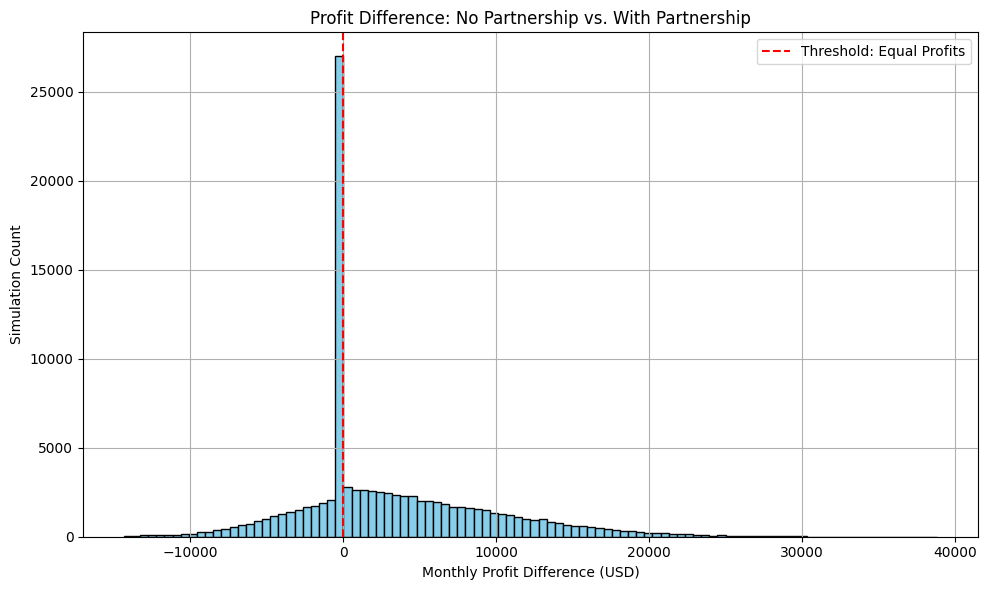

Probability that profit without partnership > with partnership: 54.34%


In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Set seed
np.random.seed(42)

# Simulation size
n_simulations = 100000

# Price and probabilities
prices = np.array([20.00, 18.50, 16.50, 15.00])
probabilities = np.array([0.25, 0.35, 0.30, 0.10])

# Simulate quantity sold and price
Q = np.random.normal(loc=3000, scale=1000, size=n_simulations)
Q = np.clip(Q, 0, None)
P = np.random.choice(prices, size=n_simulations, p=probabilities)

# Costs
Cv = 11          # variable cost per meal
Cf = 3995        # fixed cost
Cl = np.random.uniform(5040, 6860, n_simulations)  # labor cost

# Profit without partnership
R = Q * P
TC = Q * Cv + Cf + Cl
pi_no_partnership = R - TC

# Profit with partnership rules
pi_with_partnership = np.where(
    pi_no_partnership < 3500, 3500,
    np.where(
        pi_no_partnership <= 9000, pi_no_partnership,
        9000 + 0.1 * (pi_no_partnership - 9000)
    )
)

# Difference
profit_difference = pi_no_partnership - pi_with_partnership

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(profit_difference, bins=100, color='skyblue', edgecolor='black')
plt.axvline(0, color='red', linestyle='--', label='Threshold: Equal Profits')
plt.title('Profit Difference: No Partnership vs. With Partnership')
plt.xlabel('Monthly Profit Difference (USD)')
plt.ylabel('Simulation Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Probability calculation
prob = np.mean(pi_no_partnership > pi_with_partnership)
print(f"Probability that profit without partnership > with partnership: {prob * 100:.2f}%")



### Question 3 價格彈性 + 固定成本波動下的合夥選擇比較

本次模擬透過蒙地卡羅方法（Monte Carlo Simulation），將原始模型進行兩項現實面擴充，以更貼近實務經營情境：


### 模型擴展一：價格對銷售量具有需求彈性

在現實中，餐點價格與顧客購買數量並非獨立。為了反映這點，我們引入了**線性需求模型**，讓銷售量隨價格上升而下降：

* 當價格每上升 \$1，平均銷售量會下降 100 份。
* 並加入常態分佈的隨機誤差，以模擬市場波動。


### 模型擴展二：固定成本的隨機變動

原模型假設每月固定成本為固定值（\$3,995），但實際上如水電費、租金、廣告費、保險等每月都會有波動。因此，我們將各項固定成本設定為**常態或均勻分佈的隨機變數**，例如：

* 租金：常態分布，平均 \$3,000，標準差 \$200
* 廣告費：均勻分布在 \$80～\$150 之間
* 保險、水電費、雜項等也各自波動

這讓每筆模擬能真實反映出不同月份的營運條件。


### 模擬目標與輸出

透過上述擴展，模擬進行了 100,000 次試算，並評估：

* 在不同的市場條件下，**不採用合夥方案的利潤是否高於合夥方案的獲利**。

### 📈 分析結果說明

最終的模擬結果顯示：

> **大約有 92.2% 的機率，Sanjay 在不接受合夥方案時會賺得更多。**



Probability that profit without partnership > with partnership: 92.24%


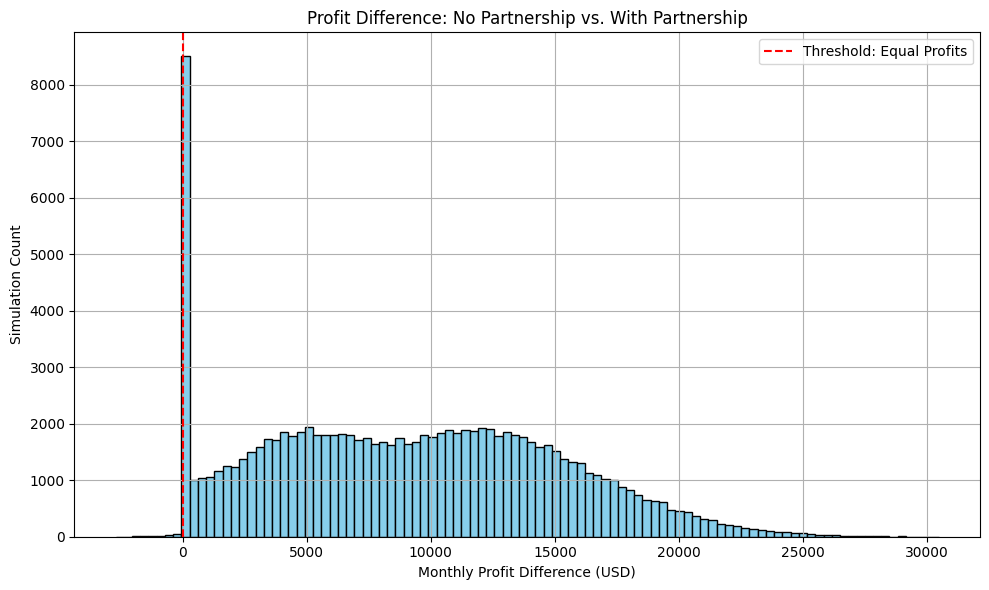

In [7]:
import numpy as np

np.random.seed(42)
n_sim = 100000

# 價格分布
prices = np.array([20.00, 18.50, 16.50, 15.00])
probabilities = np.array([0.25, 0.35, 0.30, 0.10])
P = np.random.choice(prices, size=n_sim, p=probabilities)

# 需求彈性模型：Q = max(0, a - bP + ε)
a = 6000
b = 100
epsilon = np.random.normal(0, 500, n_sim)
Q = np.maximum(0, a - b * P + epsilon)

# 成本參數
Cv = 11  # 每餐食材變動成本
Cl = np.random.uniform(5040, 6860, n_sim)  # 勞動成本

# 固定成本子項目（波動化）
Rent = np.random.normal(3000, 200, n_sim)
Leased = np.random.uniform(250, 300, n_sim)
Utilities = np.random.normal(265, 30, n_sim)
Insurance = np.random.normal(155, 10, n_sim)
Loan = 125  # 假設不變
Ad = np.random.uniform(80, 150, n_sim)
Misc = np.random.uniform(50, 100, n_sim)

# 合併所有固定成本
Cf = Rent + Leased + Utilities + Insurance + Loan + Ad + Misc

# 收入與總成本
R = Q * P
TC = Q * Cv + Cf + Cl
pi = R - TC  # 無合夥下獲利

# 合夥方案收入計算
pi_with = np.where(pi < 3500, 3500,
            np.where(pi <= 9000, pi, 9000 + 0.1 * (pi - 9000)))

# 機率估算
prob = np.mean(pi > pi_with)
print(f"Probability that profit without partnership > with partnership: {prob * 100:.2f}%")

profit_difference = pi - pi_with
plt.figure(figsize=(10, 6))
plt.hist(profit_difference, bins=100, color='skyblue', edgecolor='black')
plt.axvline(0, color='red', linestyle='--', label='Threshold: Equal Profits')
plt.title('Profit Difference: No Partnership vs. With Partnership')
plt.xlabel('Monthly Profit Difference (USD)')
plt.ylabel('Simulation Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()